In [1]:
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from scipy.stats import sem, t

def eval_std_ci(truth_df, hyps_df):
    evs_scores = []
    mae_scores = []
    mse_scores = []
    rmse_scores = []
    r2_scores = []
    fold_indices = [(0, 17), (17, 35), (35, 52), (52, 69), (69, 86)]

    for start, end in fold_indices:
        truth = np.array(truth_df[start:end])
        hyps = np.array(hyps_df[start:end])
        # hyps_binary = (hyps >= 0.5).astype(int)

        evs = explained_variance_score(truth, hyps)
        evs_scores.append(evs)
        mae = mean_absolute_error(truth, hyps)
        mae_scores.append(mae)
        mse = mean_squared_error(truth, hyps)
        mse_scores.append(mse)
        rmse = np.sqrt(mean_squared_error(truth, hyps))
        rmse_scores.append(rmse)
        r2 = r2_score(truth, hyps)
        r2_scores.append(r2)

    mean_evs = np.mean(evs_scores)
    std_evs = np.std(evs_scores)
    mean_mae = np.mean(mae_scores)
    std_mae = np.std(mae_scores)
    mean_mse = np.mean(mse_scores)
    std_mse = np.std(mse_scores)
    mean_rmse = np.mean(rmse_scores)
    std_rmse = np.std(rmse_scores)
    mean_r2 = np.mean(r2_scores)
    std_r2 = np.std(r2_scores)

    conf_interval_evs = t.interval(0.95, len(evs_scores)-1, loc=mean_evs, scale=std_evs/np.sqrt(len(evs_scores)))
    conf_interval_mae = t.interval(0.95, len(mae_scores)-1, loc=mean_mae, scale=std_mae/np.sqrt(len(mae_scores)))
    conf_interval_mse = t.interval(0.95, len(mse_scores)-1, loc=mean_mse, scale=std_mse/np.sqrt(len(mse_scores)))
    conf_interval_rmse = t.interval(0.95, len(rmse_scores)-1, loc=mean_rmse, scale=std_rmse/np.sqrt(len(rmse_scores)))
    conf_interval_r2 = t.interval(0.95, len(r2_scores)-1, loc=mean_r2, scale=std_r2/np.sqrt(len(r2_scores)))

    def adjust_confidence_interval(conf_interval):
        return (max(0, min(conf_interval[0], 1)), max(0, min(conf_interval[1], 1)))

    conf_interval_evs = adjust_confidence_interval(conf_interval_evs)
    conf_interval_mae = adjust_confidence_interval(conf_interval_mae)
    conf_interval_mse = adjust_confidence_interval(conf_interval_mse)
    conf_interval_rmse = adjust_confidence_interval(conf_interval_rmse)
    conf_interval_r2 = adjust_confidence_interval(conf_interval_r2)

    return evs_scores, mae_scores, mse_scores, rmse_scores, r2_scores, \
    mean_evs, mean_mae, mean_mse, mean_rmse, mean_r2, \
    std_evs, std_mae, std_mse, std_rmse, std_r2, \
    conf_interval_evs, conf_interval_mae, conf_interval_mse, conf_interval_rmse, conf_interval_r2

## eGeMAPS

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
# os.environ['CUDA_VISIBLE_DEVICES']='0,1'
os.environ['CUDA_LAUNCH_BLOCKING']='1'
import torch
# torch.cuda.set_device(0)
print(torch.cuda.current_device())
#! python
# -*- coding: utf-8 -*-
# Author: kun
# @Time: 2019-10-29 20:29

import yaml
import argparse
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

class Para(object):
    a=1

def find_file(x):
        # return int(x.split('/')[-1].replace("CTT.wav", ""))
        return int(x.split('\\')[-1].replace("CTT.wav", ""))

def file_str(x):
    return int(x.replace("CTT", ""))

def find_5fold(x):
    return x[x.find("CTT5-")+5]
    
def force_cudnn_initialization():
    s = 32
    dev = torch.device('cuda:0')
    torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))
    
#force_cudnn_initialization()
def main():
    # For reproducibility, comment these may speed up training
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print("start")
    df1 = pd.read_csv('preprocess_input_CTT5_2_e_16.csv')
    df1['find_5fold'] = df1['file'].map(find_5fold)
    df1['file']=df1['file'].map(find_file)
    df1 = df1.sort_values(by='file', ascending=True)
    df1.set_index("file" , inplace=True)
    df1 = df1.drop(8)
    df3 = df1.iloc[:,-1]
    df1 = df1.drop(columns = ['start', 'end', 'find_5fold'])

    df2 = pd.read_csv('data/MMSE.txt', sep=' ')
    df2['file']=df2['file'].map(file_str)
    df2.set_index("file" , inplace=True)

    feature = df1.to_numpy()
#     feature = torch.from_numpy(feature_numpy.astype(np.float32))

    target = df2.to_numpy()
#     target = torch.from_numpy(target_numpy.astype(np.float32))
#     target = target.view(target.shape[0], 1)

    n_samples, n_features = feature.shape
    print(n_samples, n_features)
    
    
    alldf =pd.DataFrame()
    for fold in range(0,5):
        # 5 fold
        train = []
        valid = []
        t_tra = []
        t_val = []
        name = []
        idx = 0
#         df =pd.DataFrame()
        for i in (df3.index):
            if(int(df3[i]) != fold+1):
                train.append(feature[idx])
                t_tra.append(target[idx])
            else:
                valid.append(feature[idx])
                t_val.append(target[idx])
                name.append(i)
            idx += 1

        train = np.array(train)
        train = torch.from_numpy(train.astype(np.float32))

        t_tra = np.array(t_tra)
        t_tra = torch.from_numpy(t_tra.astype(np.float32))
        t_tra = t_tra.view(t_tra.shape[0], 1)
        
        valid = np.array(valid)
        valid = torch.from_numpy(valid.astype(np.float32))

        t_val = np.array(t_val)
        t_val = torch.from_numpy(t_val.astype(np.float32))
        t_val = t_val.view(t_val.shape[0], 1)
        
        name = np.array(name)
        name = torch.from_numpy(name.astype(int))
        
        print("fold: ", fold)
        
        n_samples, n_features = train.shape
#         print(n_samples, n_features)
        n_samples, n_features = valid.shape
#         print(n_samples, n_features)

        regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))

        # Fit the model to the data
        regr.fit(train, t_tra.ravel())
#         print(reg.coef_)
        y_predicted = regr.predict(train)
#         loss = mean_squared_error(t_tra, y_predicted)
        y_predicted_val = regr.predict(valid)
#         loss_val = mean_squared_error(t_val, y_predicted_val)
#         print("loss ", loss, "loss_val", loss_val)
        
#         print(t_val.ravel())
        y_predicted_val = torch.from_numpy(y_predicted_val.astype(np.float32))
        y_predicted_val = y_predicted_val.view(y_predicted_val.shape[0], 1)
#         print(y_predicted_val.ravel())
        df = pd.DataFrame(
            {'name': name,
             'hyps': torch.flatten(y_predicted_val).detach().numpy(),
             'truth': torch.flatten(t_val).detach().numpy()
            })
        alldf = pd.concat([alldf, df])#
        # df.to_csv(f'MMSE_result/5folds_MMSE_{fold+1}_acoustic_e.csv', index=False)
    alldf.to_csv(f'MMSE_result/acoustic_e.csv', index=False)  
    return True


0


In [2]:
# res = False
# import time
# while (res == False):
# #     print(res)
#     time.sleep(2)
#     try:
#         res = main()
#     except:
#         continue
main()

start
85 88
fold:  0
fold:  1
fold:  2
fold:  3
fold:  4


True

In [2]:
import pandas as pd
fivefolds_1k_e = pd.read_csv('MMSE_result/acoustic_e.csv')
# fivefolds_1k['result'] = np.where(fivefolds_1k['hyps'] >= 0.5,1,0)
fivefolds_1k_e.head(50)

,name,hyps,truth
0,15,29.541512,30.0
1,16,28.689346,16.0
2,22,29.639217,29.0
3,28,28.458927,26.0
4,34,29.737509,30.0
5,35,29.259119,26.0
6,40,27.591623,26.0
7,42,29.694645,30.0
8,51,29.584349,30.0
9,53,28.918709,30.0


In [3]:
fivefolds_1k_e.tail(35)

,name,hyps,truth
50,93,27.982350,30.0
51,98,29.263922,30.0
52,4,29.255670,23.0
53,6,29.248512,30.0
54,7,29.255670,30.0
55,9,29.139833,5.0
56,12,29.141222,20.0
57,17,29.255670,26.0
58,21,29.712282,28.0
59,29,29.386484,30.0


In [4]:
# fivefolds_1k = fivefolds_1k.drop([24])

In [5]:
# fivefolds_1_result = fivefolds_1k['result'].tolist()
fivefolds_1_hyps_e = fivefolds_1k_e['hyps'].tolist()
# fivefolds_1_truth = [int(i) for i in fivefolds_1k['truth'].tolist()]
fivefolds_1_truth_e = fivefolds_1k_e['truth'].tolist()

In [6]:
import numpy as np
from sklearn import metrics
print('mae: ', metrics.mean_absolute_error(fivefolds_1_truth_e, fivefolds_1_hyps_e))
print('mse: ', metrics.mean_squared_error(fivefolds_1_truth_e, fivefolds_1_hyps_e))
print('rmse: ', np.sqrt(metrics.mean_squared_error(fivefolds_1_truth_e, fivefolds_1_hyps_e)))
print('r2: ', metrics.r2_score(fivefolds_1_truth_e, fivefolds_1_hyps_e))
print('evs: ', metrics.explained_variance_score(fivefolds_1_truth_e, fivefolds_1_hyps_e))

evs_scores, mae_scores, mse_scores, rmse_scores, r2_scores, \
mean_evs, mean_mae, mean_mse, mean_rmse, mean_r2, \
std_evs, std_mae, std_mse, std_rmse, std_r2, \
conf_interval_evs, conf_interval_mae, conf_interval_mse, conf_interval_rmse, conf_interval_r2 = eval_std_ci(fivefolds_1_truth_e, fivefolds_1_hyps_e)
print(f"EVS Scores: {evs_scores}, MAE Scores: {mae_scores}, MSE Scores: {mse_scores}, RMSE Scores: {rmse_scores}, R2 Scores: {r2_scores}")
print(f"Mean MAE Scores: {mean_mae}, Std Dev: {std_mae}, 95% Confidence Interval: {conf_interval_mae}")
print(f"Mean MSE Scores: {mean_mse}, Std Dev: {std_mse}, 95% Confidence Interval: {conf_interval_mse}")
print(f"Mean RMSE Scores: {mean_rmse}, Std Dev: {std_rmse}, 95% Confidence Interval: {conf_interval_rmse}")
print(f"Mean R2: {mean_r2}, Std Dev: {std_r2}, 95% Confidence Interval: {conf_interval_r2}")
print(f"Mean EVS Score: {mean_evs}, Std Dev: {std_evs}, 95% Confidence Interval: {conf_interval_evs}")

mae:  3.004625329411765
mse:  33.53873741412281
rmse:  5.791263887453481
r2:  -0.11535413437160402
evs:  0.056960315381649806
EVS Scores: [0.15214649427597615, 0.0816929506692452, -0.004338634395348873, 0.013548877897427425, 0.11716606776205607], MAE Scores: [1.561982470588235, 4.632164777777778, 2.1822629411764707, 4.006586882352941, 2.515627375], MSE Scores: [10.830395732098232, 55.94896390476489, 16.92415480877812, 58.29166268222181, 23.807856570125132], RMSE Scores: [3.2909566591035855, 7.479904003713209, 4.11389776353012, 7.634897686427881, 4.8793295205514795], R2 Scores: [0.08906159296379834, -0.29260298810209817, -0.13062430414629578, -0.18752929050910083, -0.030225030755921978]
Mean MAE Scores: 2.979724889379085, Std Dev: 1.152937879081801, 95% Confidence Interval: (1, 1)
Mean MSE Scores: 33.16060673959764, Std Dev: 20.003068893309162, 95% Confidence Interval: (1, 1)
Mean RMSE Scores: 5.479797126665255, Std Dev: 1.769867280388237, 95% Confidence Interval: (1, 1)
Mean R2: -0.110

<Axes: xlabel='truth', ylabel='hyps'>

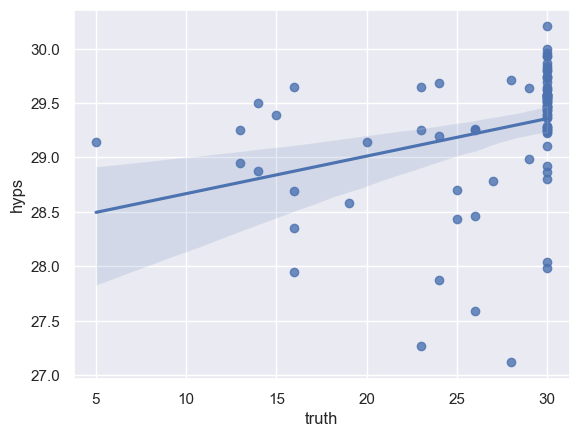

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_theme(color_codes=True)
tips = sns.load_dataset("tips")
sns.regplot(x="truth", y="hyps", data=fivefolds_1k_e)

## ComParE

In [9]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
# os.environ['CUDA_VISIBLE_DEVICES']='0,1'
os.environ['CUDA_LAUNCH_BLOCKING']='1'
import torch
# torch.cuda.set_device(0)
print(torch.cuda.current_device())
#! python
# -*- coding: utf-8 -*-
# Author: kun
# @Time: 2019-10-29 20:29

import yaml
import argparse
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

class Para(object):
    a=1

def find_file(x):
        # return int(x.split('/')[-1].replace("CTT.wav", ""))
        return int(x.split('\\')[-1].replace("CTT.wav", ""))

def file_str(x):
    return int(x.replace("CTT", ""))

def find_5fold(x):
    return x[x.find("CTT5-")+5]
    
def force_cudnn_initialization():
    s = 32
    dev = torch.device('cuda:0')
    torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))
    
#force_cudnn_initialization()
def main():
    # For reproducibility, comment these may speed up training
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print("start")
    df1 = pd.read_csv('preprocess_input_CTT5_2_c_16.csv')
    df1['find_5fold'] = df1['file'].map(find_5fold)
    df1['file']=df1['file'].map(find_file)
    df1 = df1.sort_values(by='file', ascending=True)
    df1.set_index("file" , inplace=True)
    df1 = df1.drop(8)
    df3 = df1.iloc[:,-1]
    df1 = df1.drop(columns = ['start', 'end', 'find_5fold'])

    df2 = pd.read_csv('data/MMSE.txt', sep=' ')
    df2['file']=df2['file'].map(file_str)
    df2.set_index("file" , inplace=True)

    feature = df1.to_numpy()
#     feature = torch.from_numpy(feature_numpy.astype(np.float32))

    target = df2.to_numpy()
#     target = torch.from_numpy(target_numpy.astype(np.float32))
#     target = target.view(target.shape[0], 1)

    n_samples, n_features = feature.shape
    print(n_samples, n_features)
    
    
    alldf =pd.DataFrame()
    for fold in range(0,5):
        # 5 fold
        train = []
        valid = []
        t_tra = []
        t_val = []
        name = []
        idx = 0
#         df =pd.DataFrame()
        for i in (df3.index):
            if(int(df3[i]) != fold+1):
                train.append(feature[idx])
                t_tra.append(target[idx])
            else:
                valid.append(feature[idx])
                t_val.append(target[idx])
                name.append(i)
            idx += 1

        train = np.array(train)
        train = torch.from_numpy(train.astype(np.float32))

        t_tra = np.array(t_tra)
        t_tra = torch.from_numpy(t_tra.astype(np.float32))
        t_tra = t_tra.view(t_tra.shape[0], 1)
        
        valid = np.array(valid)
        valid = torch.from_numpy(valid.astype(np.float32))

        t_val = np.array(t_val)
        t_val = torch.from_numpy(t_val.astype(np.float32))
        t_val = t_val.view(t_val.shape[0], 1)
        
        name = np.array(name)
        name = torch.from_numpy(name.astype(int))
        
        print("fold: ", fold)
        
        n_samples, n_features = train.shape
#         print(n_samples, n_features)
        n_samples, n_features = valid.shape
#         print(n_samples, n_features)

        regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))

        # Fit the model to the data
        regr.fit(train, t_tra.ravel())
#         print(reg.coef_)
        y_predicted = regr.predict(train)
#         loss = mean_squared_error(t_tra, y_predicted)
        y_predicted_val = regr.predict(valid)
#         loss_val = mean_squared_error(t_val, y_predicted_val)
#         print("loss ", loss, "loss_val", loss_val)
        
#         print(t_val.ravel())
        y_predicted_val = torch.from_numpy(y_predicted_val.astype(np.float32))
        y_predicted_val = y_predicted_val.view(y_predicted_val.shape[0], 1)
#         print(y_predicted_val.ravel())
        df = pd.DataFrame(
            {'name': name,
             'hyps': torch.flatten(y_predicted_val).detach().numpy(),
             'truth': torch.flatten(t_val).detach().numpy()
            })
        alldf = pd.concat([alldf, df])
        # df.to_csv(f'MMSE_result/5folds_MMSE_{fold+1}_acoustic_c.csv', index=False)
    alldf.to_csv(f'MMSE_result/acoustic_c.csv', index=False) 
    return True


0


In [10]:
main()

start
85 6373
fold:  0
fold:  1
fold:  2
fold:  3
fold:  4


True

In [7]:
fivefolds_1k_c = pd.read_csv('MMSE_result/acoustic_c.csv')
# fivefolds_1k['result'] = np.where(fivefolds_1k['hyps'] >= 0.5,1,0)
fivefolds_1k_c.head(50)

,name,hyps,truth
0,15,29.488907,30.0
1,16,28.393454,16.0
2,22,29.596760,29.0
3,28,28.810232,26.0
4,34,29.566187,30.0
5,35,29.019995,26.0
6,40,28.277576,26.0
7,42,29.490294,30.0
8,51,28.884203,30.0
9,53,28.951626,30.0


In [8]:
fivefolds_1k_c.tail(35)

,name,hyps,truth
50,93,29.558151,30.0
51,98,29.154097,30.0
52,4,29.572380,23.0
53,6,29.425406,30.0
54,7,29.562170,30.0
55,9,29.384418,5.0
56,12,28.607327,20.0
57,17,28.562534,26.0
58,21,29.247011,28.0
59,29,29.478594,30.0


In [9]:
# fivefolds_1_result = fivefolds_1k['result'].tolist()
fivefolds_1_hyps_c = fivefolds_1k_c['hyps'].tolist()
# fivefolds_1_truth = [int(i) for i in fivefolds_1k['truth'].tolist()]
fivefolds_1_truth_c = fivefolds_1k_c['truth'].tolist()

In [10]:
from sklearn import metrics
print('mae: ', metrics.mean_absolute_error(fivefolds_1_truth_c, fivefolds_1_hyps_c))
print('mse: ', metrics.mean_squared_error(fivefolds_1_truth_c, fivefolds_1_hyps_c))
print('rmse: ', np.sqrt(metrics.mean_squared_error(fivefolds_1_truth_c, fivefolds_1_hyps_c)))
print('r2: ', metrics.r2_score(fivefolds_1_truth_c, fivefolds_1_hyps_c))
print('evs: ', metrics.explained_variance_score(fivefolds_1_truth_c, fivefolds_1_hyps_c))

evs_scores, mae_scores, mse_scores, rmse_scores, r2_scores, \
mean_evs, mean_mae, mean_mse, mean_rmse, mean_r2, \
std_evs, std_mae, std_mse, std_rmse, std_r2, \
conf_interval_evs, conf_interval_mae, conf_interval_mse, conf_interval_rmse, conf_interval_r2 = eval_std_ci(fivefolds_1_truth_c, fivefolds_1_hyps_c)
print(f"EVS Scores: {evs_scores}, MAE Scores: {mae_scores}, MSE Scores: {mse_scores}, RMSE Scores: {rmse_scores}, R2 Scores: {r2_scores}")
print(f"Mean MAE Scores: {mean_mae}, Std Dev: {std_mae}, 95% Confidence Interval: {conf_interval_mae}")
print(f"Mean MSE Scores: {mean_mse}, Std Dev: {std_mse}, 95% Confidence Interval: {conf_interval_mse}")
print(f"Mean RMSE Scores: {mean_rmse}, Std Dev: {std_rmse}, 95% Confidence Interval: {conf_interval_rmse}")
print(f"Mean R2: {mean_r2}, Std Dev: {std_r2}, 95% Confidence Interval: {conf_interval_r2}")
print(f"Mean EVS Score: {mean_evs}, Std Dev: {std_evs}, 95% Confidence Interval: {conf_interval_evs}")

mae:  3.1142008941176473
mse:  34.459973355327634
rmse:  5.870261779114083
r2:  -0.14599047893840478
evs:  0.02590879753407105
EVS Scores: [0.12699730946800325, 0.045084991301778454, -0.048668516907051984, 0.014536895656022675, 0.05028352465859254], MAE Scores: [1.7791313529411763, 4.753285444444444, 2.306520294117647, 3.8143517058823533, 2.8029925624999996], MSE Scores: [10.873560170275235, 57.56468955128154, 17.843931530298647, 58.996663041022636, 25.112043292040056], RMSE Scores: [3.2975081759224243, 7.587139747710038, 4.22420779913804, 7.680928527269515, 5.011191803557319], R2 Scores: [0.08543105669105278, -0.32993150417963624, -0.1920703218345603, -0.2018916973675131, -0.0866604264304014]
Mean MAE Scores: 3.091256271977124, Std Dev: 1.068249624476477, 95% Confidence Interval: (1, 1)
Mean MSE Scores: 34.07817751698362, Std Dev: 20.272857421942394, 95% Confidence Interval: (1, 1)
Mean RMSE Scores: 5.560195210719468, Std Dev: 1.7783157019145734, 95% Confidence Interval: (1, 1)
Mean R

<Axes: xlabel='truth', ylabel='hyps'>

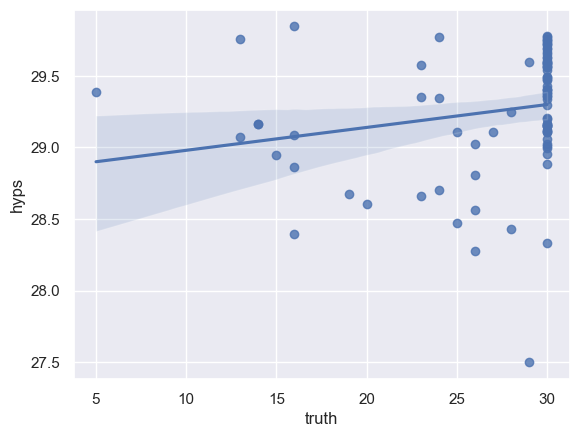

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_theme(color_codes=True)
tips = sns.load_dataset("tips")
sns.regplot(x="truth", y="hyps", data=fivefolds_1k_c)